## Reporte: Eliminación de Anomalías y Ajuste de Intensidad

#### Nombre del alumno: Serguei Drago Dominguez Ruiz

### 1. Introducción
**Objetivos del laboratorio:**  
Familiarización con técnicas de eliminación de anomalías (ruido) y ajuste de intensidad (contraste). Implementación de soluciones propias y comparación con métodos de OpenCV.

---

### 2. Eliminación de Anomalías (Criterios 1 y 3)

#### 2.1 Selección de imágenes

- Incluir dos imágenes limpias (sin ruido).
- Mostrar con `matplotlib.pyplot.imshow`.

In [2]:
# Instalación de librerías necesarias
import sys
import subprocess

def instalar_librerias():
    packages = [
        'numpy>=1.24.0',
        'pandas>=2.0.0',
        'matplotlib>=3.7.0',
        'seaborn>=0.12.0',
        'opencv-python>=4.8.0',
        'scikit-image>=0.21.0'
    ]
    
    print("Instalando las librerías necesarias...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} instalado correctamente")
        except Exception as e:
            print(f"✗ Error instalando {package}: {str(e)}")
    print("\n¡Instalación completada! Ya puedes ejecutar el resto del notebook.")

# Ejecutar la instalación
#instalar_librerias()


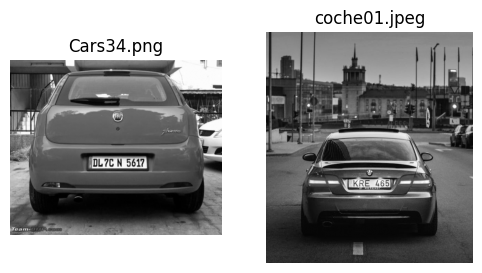

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar las imágenes
img1 = cv2.imread('images/Cars34.png')
img2 = cv2.imread('images/coche01.jpeg')

# Convertir a escala de grises
if len(img1.shape) == 3:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
if len(img2.shape) == 3:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    
def mostrar_imagenes(img1, img2, titulo1='Cars34.png', titulo2='coche01.jpeg'):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(titulo1)
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title(titulo2)
    plt.axis('off')
    plt.show()

# Ejecutar la función
mostrar_imagenes(img1, img2)


#### 2.2 Agregado de anomalías

- Añadir **ruido sal y pimienta** con una función propia:
    Esta función simula el ruido de sal y pimienta. La implementación se realiza de la siguiente manera:
    1. Se crea una copia de la imagen original para no modificarla directamente
    2. Se generan dos máscaras aleatorias usando np.random.random:
       - Una para los píxeles de sal (valor 255)
       - Una para los píxeles de pimienta (valor 0)
    3. La probabilidad total (prob) se divide entre 2 para distribuir equitativamente
       el ruido entre sal y pimienta
            # *Nota: numpy.ndarray es un array multidimensional de NumPy que permite
            # *almacenar y manipular datos numéricos de manera eficiente

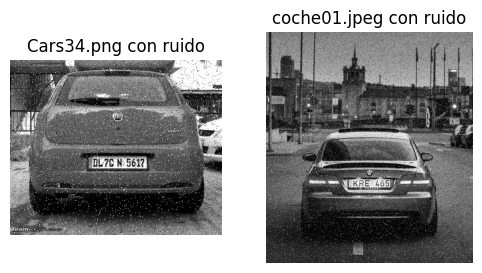

In [4]:
def add_salt_pepper(image, prob=0.05):
    """
    Args:
        image (numpy.ndarray): Imagen de entrada en escala de grises
        prob (float, optional): Probabilidad total de ruido. Por defecto 0.05 (5%)
    Returns:
        numpy.ndarray: Imagen con ruido de sal y pimienta
    """
    noisy = np.copy(image)
    # Generar máscaras aleatorias para sal (255) y pimienta (0)
    # np.random.random genera un array de números aleatorios entre 0 y 1 con la misma forma que image.shape[:2] (100x200 por ejemplo)
    # La comparación < prob/2 crea una máscara booleana donde True indica dónde agregar ruido de sal y pimienta
    salt_mask = np.random.random(image.shape[:2]) < prob/2
    pepper_mask = np.random.random(image.shape[:2]) < prob/2
    noisy[salt_mask] = 255
    noisy[pepper_mask] = 0
    return noisy

# Aplicar ruido a las imágenes
noisy_img1 = add_salt_pepper(img1)
noisy_img2 = add_salt_pepper(img2)


def mostrar_imagenes_ruido(img1, img2, titulo1='Cars34.png con ruido', titulo2='coche01.jpeg con ruido'):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(titulo1)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title(titulo2)
    plt.axis('off')
    plt.show()

# Ejecutar la función
mostrar_imagenes_ruido(noisy_img1, noisy_img2)

#### 2.3 Técnica de eliminación de ruido (1) – **Desarrollo propio**

En esta sección, implementamos un filtro de mediana desde cero para comprender a fondo el proceso de eliminación de ruido en imágenes digitales. El filtro de mediana es particularmente efectivo para eliminar el ruido de tipo "sal y pimienta" debido a su naturaleza no lineal.

**Fundamento teórico:**
El filtro de mediana opera bajo el siguiente principio:
1. Para cada píxel en la imagen, se considera una ventana de vecindad (en nuestro caso 3x3 píxeles)
2. Se ordenan todos los valores de intensidad en esta ventana
3. Se selecciona el valor mediano como nuevo valor para el píxel central
4. Este proceso se repite para cada píxel en la imagen


**Características clave de nuestra implementación:**
- **Manejo de bordes:** Utilizamos un enfoque conservador donde los píxeles del borde mantienen sus valores originales
- **Flexibilidad:** El parámetro `k` permite ajustar el tamaño de la ventana según las necesidades
- **Preservación de estructuras:** Al usar la mediana en lugar del promedio, se preservan mejor los bordes de la imagen

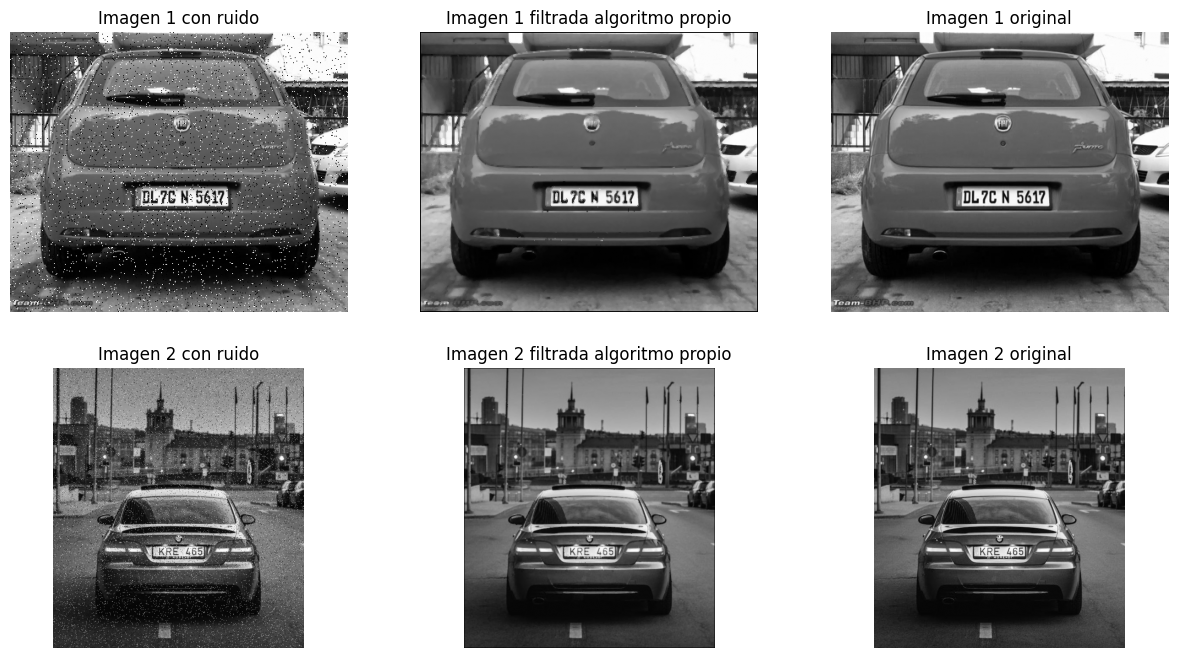

In [5]:
def filtro_mediana_manual(imagen, k=3):
    """
    Aplica un filtro de mediana manualmente sin usar funciones de OpenCV.
    
    Args:
        imagen (numpy.ndarray): Imagen de entrada en escala de grises
        k (int): Tamaño de la ventana del filtro (debe ser impar)
    
    Returns:
        numpy.ndarray: Imagen filtrada
    """
    # Asegurarse que k sea impar
    if k % 2 == 0:
        k = k + 1
    
    # Crear una copia de la imagen para el resultado
    altura, anchura = imagen.shape
    imagen_filtrada = np.zeros_like(imagen)
    
    # Calcular el padding necesario
    pad = k // 2
    
    # Aplicar el filtro de mediana
    for i in range(pad, altura - pad):
        for j in range(pad, anchura - pad):
            # Obtener la ventana de vecindad
            ventana = imagen[i-pad:i+pad+1, j-pad:j+pad+1]
            # Calcular la mediana de la ventana
            mediana = np.median(ventana)
            # Asignar el valor de la mediana al píxel central
            imagen_filtrada[i, j] = mediana
    
    return imagen_filtrada

# Aplicar el filtro de mediana manual a ambas imágenes
img1_filtrada_manual = filtro_mediana_manual(noisy_img1)
img2_filtrada_manual = filtro_mediana_manual(noisy_img2)


def mostrar_resultados(noisy_img1, img1_filtrada_manual, img1, noisy_img2, img2_filtrada_manual, img2):
    """
    Muestra las imágenes originales, con ruido y filtradas en una figura.
    
    Args:
        noisy_img1, noisy_img2: Imágenes con ruido
        img1_filtrada_manual, img2_filtrada_manual: Imágenes filtradas
        img1, img2: Imágenes originales
    """
    plt.figure(figsize=(15, 8))
    
    # Imagen 1
    plt.subplot(231)
    plt.imshow(noisy_img1, cmap='gray')
    plt.title('Imagen 1 con ruido')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(img1_filtrada_manual, cmap='gray')
    plt.title('Imagen 1 filtrada algoritmo propio')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(img1, cmap='gray')
    plt.title('Imagen 1 original')
    plt.axis('off')

    # Imagen 2
    plt.subplot(234)
    plt.imshow(noisy_img2, cmap='gray')
    plt.title('Imagen 2 con ruido')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(img2_filtrada_manual, cmap='gray')
    plt.title('Imagen 2 filtrada algoritmo propio')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(img2, cmap='gray')
    plt.title('Imagen 2 original')
    plt.axis('off')
    
    plt.show()

# Ejecutar la función
mostrar_resultados(noisy_img1, img1_filtrada_manual, img1, noisy_img2, img2_filtrada_manual, img2)

#### 2.4 Técnica de eliminación de ruido (2) – **OpenCV**

La segunda implementación utiliza la función `cv2.medianBlur()` de OpenCV, una biblioteca altamente optimizada para procesamiento de imágenes.

**Características de la implementación OpenCV:**
**Optimizaciones:**
   - Código en C++ optimizado
   - Uso de SIMD (Single Instruction, Multiple Data) y paralelización
   
**Bordes:**
   - Padding inteligente
   - Mejor preservación de bordes
 
**Rendimiento:**
   - Más rápido que implementación manual
   - Mejor uso de memoria y hardware

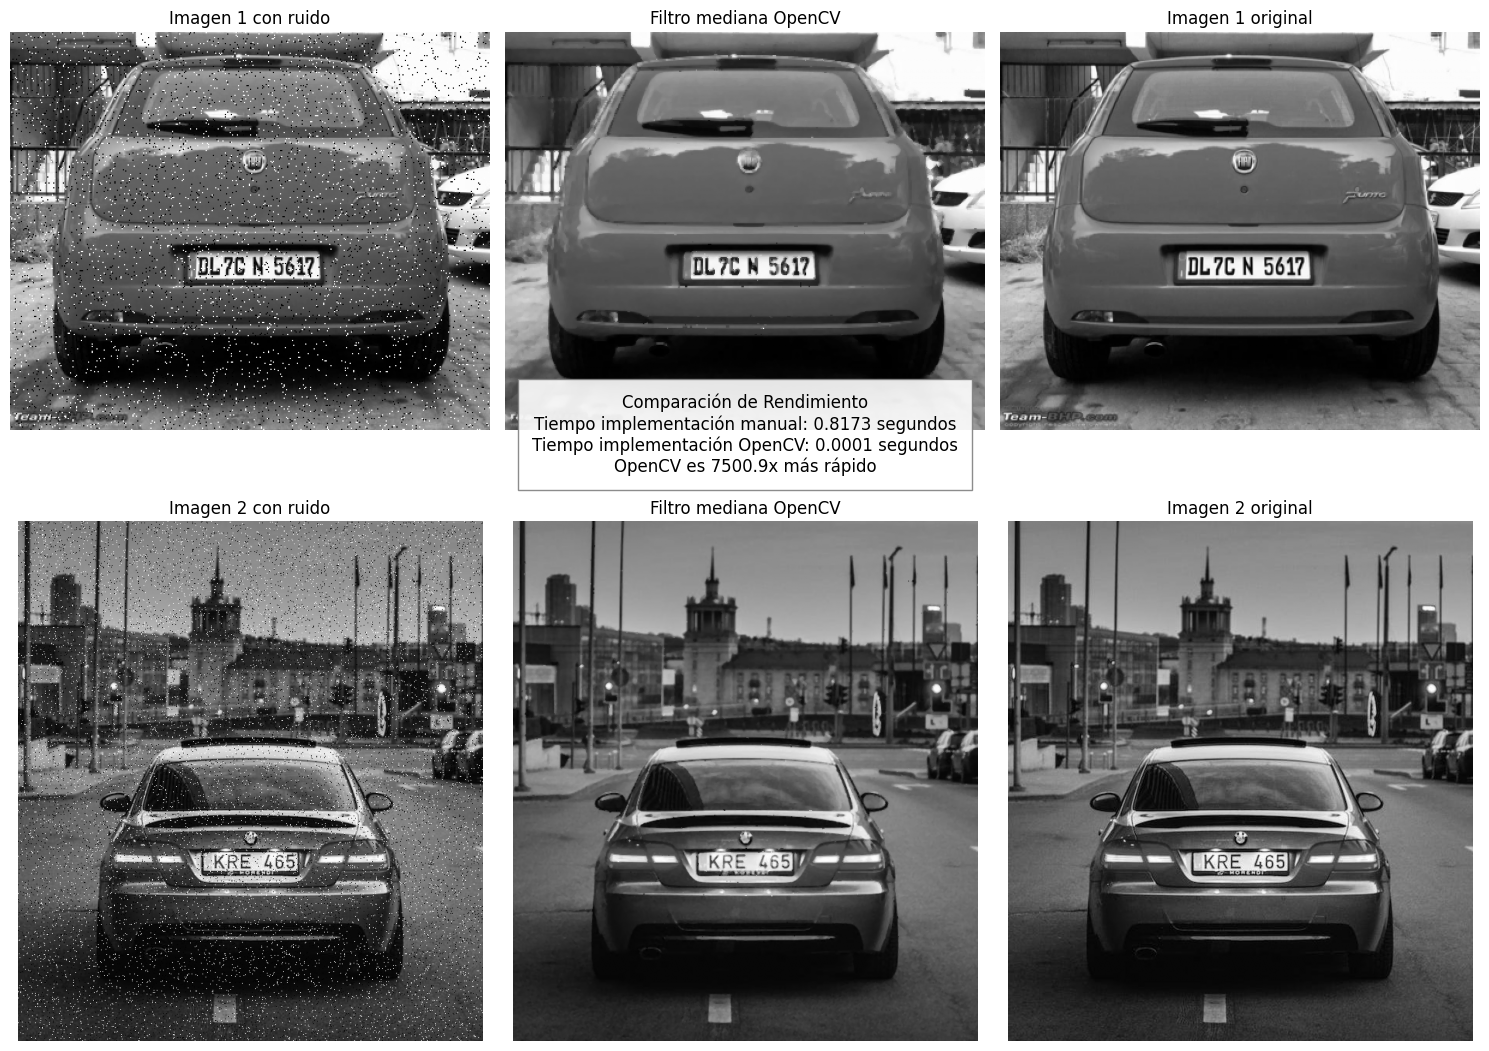

In [6]:
# Aplicar el filtro de mediana de OpenCV
"""
OpenCV proporciona una implementación optimizada del filtro de mediana a través de cv2.medianBlur.
Esta función es significativamente más rápida que la implementación manual debido a:
1. Optimizaciones a nivel de código C++
2. Posible uso de instrucciones SIMD
3. Manejo eficiente de los bordes de la imagen

Parámetros:
- ksize: Tamaño de la ventana del kernel (debe ser impar). Este parámetro determina el tamaño del área vecina que se analiza para calcular la mediana. Por ejemplo:
  - ksize=3: Analiza una ventana de 3x3 píxeles
  - ksize=5: Analiza una ventana de 5x5 píxeles
  - ksize=7: Analiza una ventana de 7x7 píxeles
  Un valor más grande eliminará más ruido pero puede suavizar demasiado los detalles de la imagen.
"""

# Aplicar el filtro a ambas imágenes
img1_filtrada_opencv = cv2.medianBlur(noisy_img1, ksize=3)
img2_filtrada_opencv = cv2.medianBlur(noisy_img2, ksize=3)

# Medir tiempos de ejecución
import time

# Medir tiempo para el filtro manual
start_time = time.time()
_ = filtro_mediana_manual(noisy_img1)
tiempo_manual = time.time() - start_time

# Medir tiempo para OpenCV
start_time = time.time()
_ = cv2.medianBlur(noisy_img1, ksize=3)
tiempo_opencv = time.time() - start_time

def plot_comparison(noisy_img1, img1_filtrada_opencv, img1, noisy_img2, img2_filtrada_opencv, img2, tiempo_manual, tiempo_opencv):
    plt.figure(figsize=(15, 11))
    
    # Primera fila: Imagen 1
    plt.subplot(231)
    plt.imshow(noisy_img1, cmap='gray')
    plt.title('Imagen 1 con ruido')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(img1_filtrada_opencv, cmap='gray')
    plt.title('Filtro mediana OpenCV')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(img1, cmap='gray')
    plt.title('Imagen 1 original')
    plt.axis('off')

    # Segunda fila: Imagen 2
    plt.subplot(234)
    plt.imshow(noisy_img2, cmap='gray')
    plt.title('Imagen 2 con ruido')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(img2_filtrada_opencv, cmap='gray')
    plt.title('Filtro mediana OpenCV')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(img2, cmap='gray')
    plt.title('Imagen 2 original')
    plt.axis('off')

    # Tercera fila: Información de rendimiento
    plt.subplot(412)
    plt.axis('off')
    plt.text(0.5, .25,
            'Comparación de Rendimiento\n' +
            f'Tiempo implementación manual: {tiempo_manual:.4f} segundos\n' +
            f'Tiempo implementación OpenCV: {tiempo_opencv:.4f} segundos\n' +
            f'OpenCV es {tiempo_manual/tiempo_opencv:.1f}x más rápido',
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', pad=10))

    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_comparison(noisy_img1, img1_filtrada_opencv, img1, noisy_img2, img2_filtrada_opencv, img2, tiempo_manual, tiempo_opencv)

#### 2.5 Métrica cuantitativa – Evaluación (Criterio 3)

Para evaluar cuantitativamente la calidad de la restauración de las imágenes, se utilizaron dos métricas principales:
 
 1. **PSNR (Peak Signal-to-Noise Ratio)**
    - Mide la relación entre la potencia máxima de la señal y la potencia del ruido
    - Se expresa en decibeles (dB)
    - Valores más altos indican mejor calidad de imagen
 
 2. **SSIM (Structural Similarity Index)**
    - Evalúa la similitud estructural entre dos imágenes
    - Rango de valores: [-1, 1], donde 1 indica imágenes idénticas
    - Considera luminancia, contraste y estructura
    - Más robusto que PSNR para evaluar la percepción humana de la calidad
 
 Estas métricas se calcularon comparando:
 - Imagen original vs. Imagen filtrada manualmente
 - Imagen original vs. Imagen filtrada con OpenCV
 
 Los resultados se presentan en una tabla comparativa que incluye:
 - Métricas para cada imagen
 - Comparación entre métodos
 - Tiempo de procesamiento


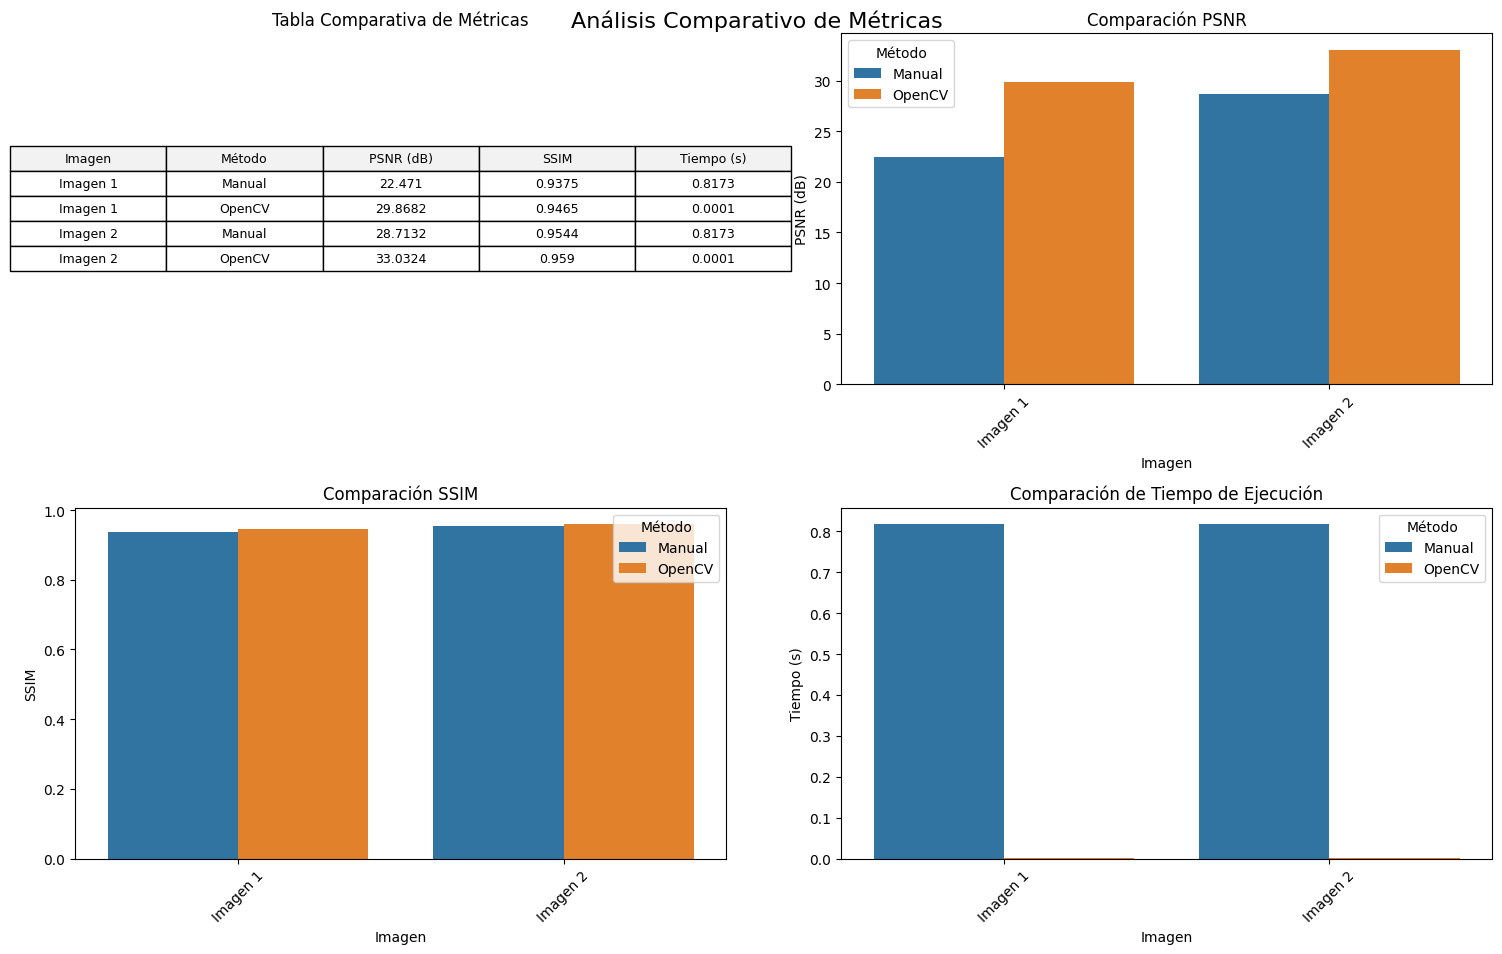

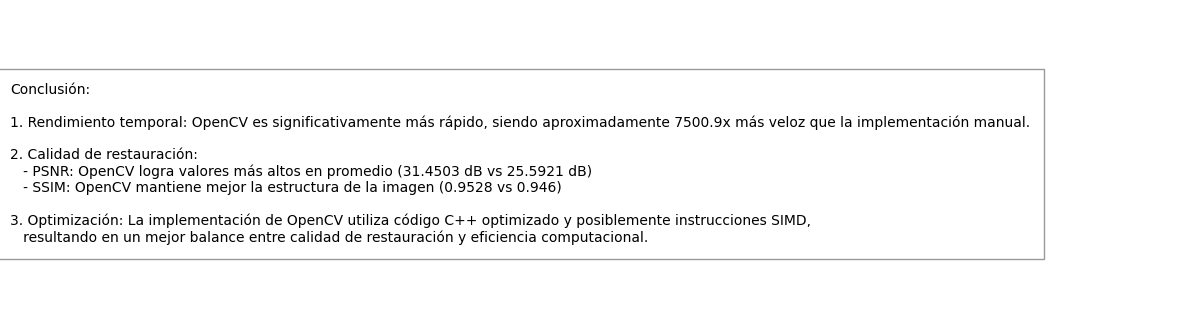

In [7]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
import pandas as pd
import seaborn as sns

# Calcular PSNR y SSIM para ambas imágenes y ambos métodos
metrics = {
    'Imagen': [],
    'Método': [],
    'PSNR (dB)': [],
    'SSIM': [],
    'Tiempo (s)': []
}

# Calcular métricas para la primera imagen
psnr_manual_1 = peak_signal_noise_ratio(img1, img1_filtrada_manual)
psnr_opencv_1 = peak_signal_noise_ratio(img1, img1_filtrada_opencv)
ssim_manual_1 = ssim(img1, img1_filtrada_manual)
ssim_opencv_1 = ssim(img1, img1_filtrada_opencv)

# Calcular métricas para la segunda imagen
psnr_manual_2 = peak_signal_noise_ratio(img2, img2_filtrada_manual)
psnr_opencv_2 = peak_signal_noise_ratio(img2, img2_filtrada_opencv)
ssim_manual_2 = ssim(img2, img2_filtrada_manual)
ssim_opencv_2 = ssim(img2, img2_filtrada_opencv)

# Agregar resultados al diccionario
for img_num, (psnr_m, psnr_o, ssim_m, ssim_o) in enumerate([(psnr_manual_1, psnr_opencv_1, ssim_manual_1, ssim_opencv_1),
                                                           (psnr_manual_2, psnr_opencv_2, ssim_manual_2, ssim_opencv_2)], 1):
    metrics['Imagen'].extend([f'Imagen {img_num}', f'Imagen {img_num}'])
    metrics['Método'].extend(['Manual', 'OpenCV'])
    metrics['PSNR (dB)'].extend([round(psnr_m, 4), round(psnr_o, 4)])
    metrics['SSIM'].extend([round(ssim_m, 4), round(ssim_o, 4)])
    metrics['Tiempo (s)'].extend([round(tiempo_manual, 4), round(tiempo_opencv, 4)])

# Crear DataFrame
df = pd.DataFrame(metrics)


def plot_metrics_analysis(df, tiempo_manual, tiempo_opencv):
    # Crear figura con subplots
    plt.figure(figsize=(15, 10))
    plt.suptitle('Análisis Comparativo de Métricas', fontsize=16, y=0.95)

    # 1. Tabla de métricas
    plt.subplot(221)
    plt.axis('off')
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*5)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Tabla Comparativa de Métricas')

    # 2. Gráfico de barras para PSNR
    plt.subplot(222)
    sns.barplot(data=df, x='Imagen', y='PSNR (dB)', hue='Método')
    plt.title('Comparación PSNR')
    plt.xticks(rotation=45)

    # 3. Gráfico de barras para SSIM
    plt.subplot(223)
    sns.barplot(data=df, x='Imagen', y='SSIM', hue='Método')
    plt.title('Comparación SSIM')
    plt.xticks(rotation=45)

    # 4. Gráfico de barras para Tiempo
    plt.subplot(224)
    sns.barplot(data=df, x='Imagen', y='Tiempo (s)', hue='Método')
    plt.title('Comparación de Tiempo de Ejecución')
    plt.xticks(rotation=45)

    plt.tight_layout()

    # Mostrar conclusión
    plt.figure(figsize=(15, 4))
    plt.axis('off')
    conclusion_text = (
        "Conclusión:\n\n"
        "1. Rendimiento temporal: OpenCV es significativamente más rápido, siendo aproximadamente "
        f"{tiempo_manual/tiempo_opencv:.1f}x más veloz que la implementación manual.\n\n"
        "2. Calidad de restauración:\n"
        f"   - PSNR: OpenCV logra valores más altos en promedio ({round(df[df['Método']=='OpenCV']['PSNR (dB)'].mean(), 4)} dB vs "
        f"{round(df[df['Método']=='Manual']['PSNR (dB)'].mean(), 4)} dB)\n"
        f"   - SSIM: OpenCV mantiene mejor la estructura de la imagen ({round(df[df['Método']=='OpenCV']['SSIM'].mean(), 4)} vs "
        f"{round(df[df['Método']=='Manual']['SSIM'].mean(), 4)})\n\n"
        "3. Optimización: La implementación de OpenCV utiliza código C++ optimizado y posiblemente instrucciones SIMD,\n"
        "   resultando en un mejor balance entre calidad de restauración y eficiencia computacional."
    )
    plt.text(0, 0.5, conclusion_text, ha='left', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, pad=10))

    plt.show()

# Ejecutar la función
plot_metrics_analysis(df, tiempo_manual, tiempo_opencv)


#### **3. Ajuste de Intensidad (Criterios 2 y 4)**

 En esta sección se realiza el ajuste de intensidad en imágenes de bajo contraste, siguiendo los criterios mostrados en la imagen de referencia:
 
 3.1. **Selección de imágenes que requieren mejora de contraste:**
    - Se seleccionan dos imágenes con bajo contraste: `coche11.jpeg` y `coche02.jpeg`.

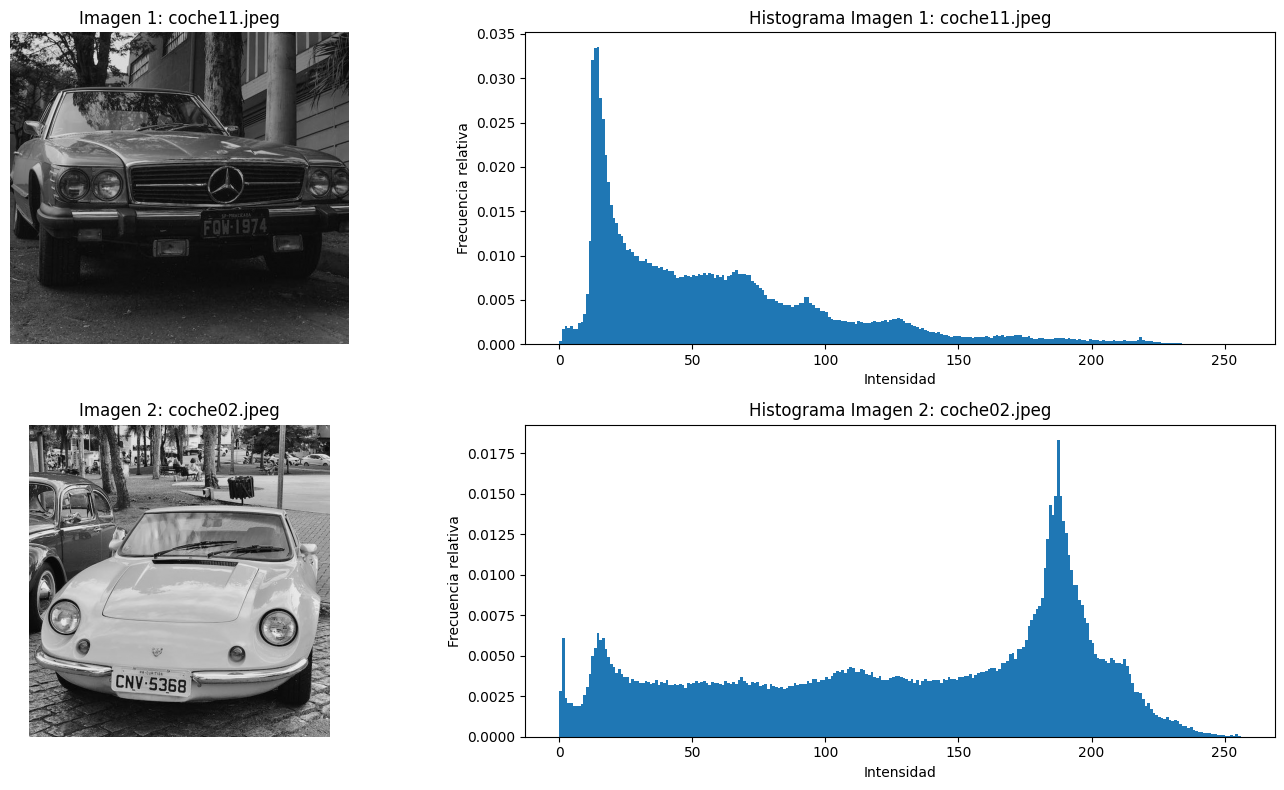

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Cargar las imágenes de bajo contraste
img_low1 = cv2.imread('images/coche11.jpeg')
img_low2 = cv2.imread('images/coche02.jpeg')

# Convertir a escala de grises
if len(img_low1.shape) == 3:
    img_low1_gray = cv2.cvtColor(img_low1, cv2.COLOR_BGR2GRAY)
if len(img_low2.shape) == 3:
    img_low2_gray = cv2.cvtColor(img_low2, cv2.COLOR_BGR2GRAY)

def mostrar_imagenes_histogramas(img1, img2, titulo1="Imagen 1", titulo2="Imagen 2"):
    plt.figure(figsize=(15, 8))
    
    # Primera imagen y su histograma
    plt.subplot(221)
    plt.imshow(img1, cmap='gray')
    plt.title(f'{titulo1}')
    plt.axis('off')
    
    plt.subplot(222)
    plt.hist(img1.ravel(), bins=256, range=[0,256], density=True)
    plt.title(f'Histograma {titulo1}')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen y su histograma
    plt.subplot(223)
    plt.imshow(img2, cmap='gray')
    plt.title(f'{titulo2}')
    plt.axis('off')
    
    plt.subplot(224)
    plt.hist(img2.ravel(), bins=256, range=[0,256], density=True)
    plt.title(f'Histograma {titulo2}')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función con las imágenes
mostrar_imagenes_histogramas(img_low1_gray, img_low2_gray, 
                           "Imagen 1: coche11.jpeg", 
                           "Imagen 2: coche02.jpeg")

#### 3.2. **Aplicación de dos técnicas para mejorar el contraste:**

##### Técnica 1: Ecualización de histograma manual (desarrollo propio).

La función `ecualizacion_histograma_manual` implementa la ecualización de histograma de manera manual siguiendo estos pasos:
 
1. **Cálculo del histograma**: 
   - Se crea un array de ceros de tamaño 256 (para cada nivel de intensidad posible)
   - Se recorre la imagen pixel por pixel contando la frecuencia de cada nivel de intensidad
 
2. **Cálculo de la función de distribución acumulativa (CDF)**:
   - Se calcula la suma acumulativa del histograma
   - Esto nos da la probabilidad acumulada de cada nivel de intensidad
 
3. **Normalización del CDF**:
   - Se normaliza el CDF al rango [0, 255]
   - Se usa la fórmula: (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
   - Se convierte a tipo uint8 para mantener los valores en el rango correcto
 
4. **Mapeo de intensidades**:
    - Se usa el CDF normalizado como tabla de búsqueda
    - Cada pixel de la imagen original se reemplaza por su valor correspondiente en el CDF normalizado

Este proceso mejora el contraste de la imagen al distribuir los niveles de intensidad de manera más uniforme a lo largo del rango disponible.


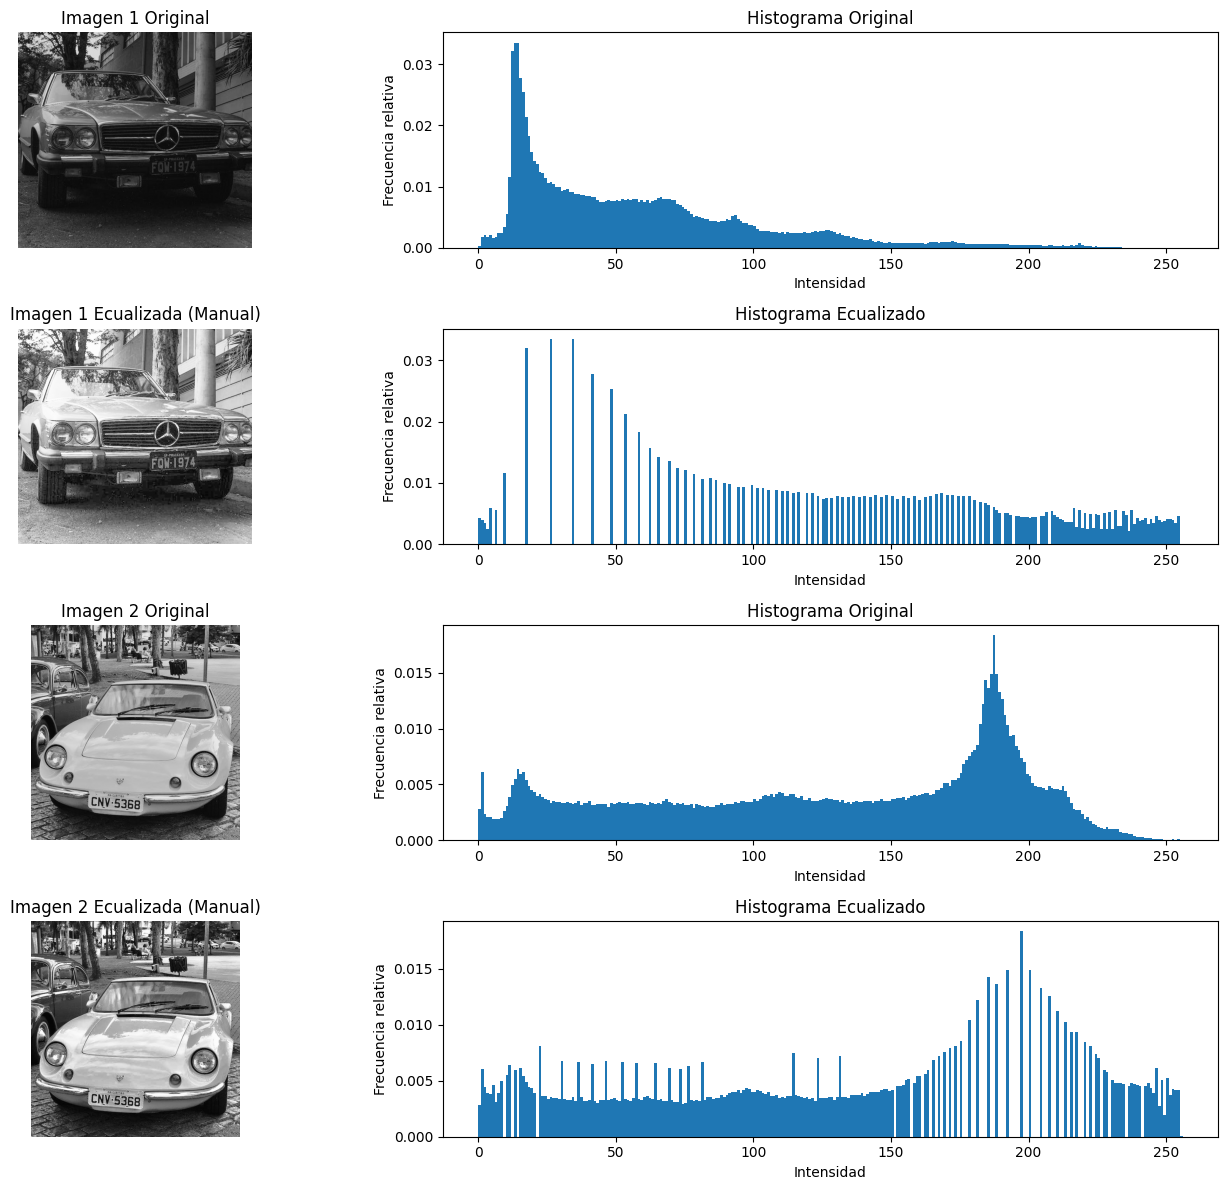

In [9]:
def ecualizacion_histograma_manual(imagen):
    """
    Implementación manual de ecualización de histograma.
    
    Args:
        imagen (numpy.ndarray): Imagen en escala de grises
        
    Returns:
        numpy.ndarray: Imagen con histograma ecualizado
    """
    # Obtener dimensiones de la imagen
    altura, anchura = imagen.shape
    total_pixeles = altura * anchura
    
    # Calcular histograma
    histograma = np.zeros(256)
    for i in range(altura):
        for j in range(anchura):
            histograma[imagen[i,j]] += 1
            
    # Calcular CDF (Cumulative Distribution Function)
    cdf = np.cumsum(histograma)
    
    # Normalizar CDF
    cdf_normalizado = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf_normalizado = cdf_normalizado.astype(np.uint8)
    
    # Crear imagen ecualizada usando el mapeo del CDF
    imagen_ecualizada = cdf_normalizado[imagen]
    
    return imagen_ecualizada

# Aplicar ecualización manual a ambas imágenes
img1_eq_manual = ecualizacion_histograma_manual(img_low1_gray)
img2_eq_manual = ecualizacion_histograma_manual(img_low2_gray)


def visualizar_resultados(img_orig1, img_eq1, img_orig2, img_eq2):
    plt.figure(figsize=(15, 12))
    
    # Primera imagen
    plt.subplot(421)
    plt.imshow(img_orig1, cmap='gray')
    plt.title('Imagen 1 Original')
    plt.axis('off')
    
    plt.subplot(422)
    plt.hist(img_orig1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(423)
    plt.imshow(img_eq1, cmap='gray')
    plt.title('Imagen 1 Ecualizada (Manual)')
    plt.axis('off')
    
    plt.subplot(424)
    plt.hist(img_eq1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen
    plt.subplot(425)
    plt.imshow(img_orig2, cmap='gray')
    plt.title('Imagen 2 Original')
    plt.axis('off')
    
    plt.subplot(426)
    plt.hist(img_orig2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(427)
    plt.imshow(img_eq2, cmap='gray')
    plt.title('Imagen 2 Ecualizada (Manual)')
    plt.axis('off')
    
    plt.subplot(428)
    plt.hist(img_eq2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
visualizar_resultados(img_low1_gray, img1_eq_manual, img_low2_gray, img2_eq_manual)

##### Técnica 2 de Ajuste de Intensidad – Usando OpenCV

En esta sección aplicamos la técnica de **ecualización de histograma** utilizando la función integrada de OpenCV: `cv2.equalizeHist`. Esta técnica mejora el contraste redistribuyendo los niveles de intensidad de una imagen en escala de grises, de forma que las intensidades estén más uniformemente distribuidas.

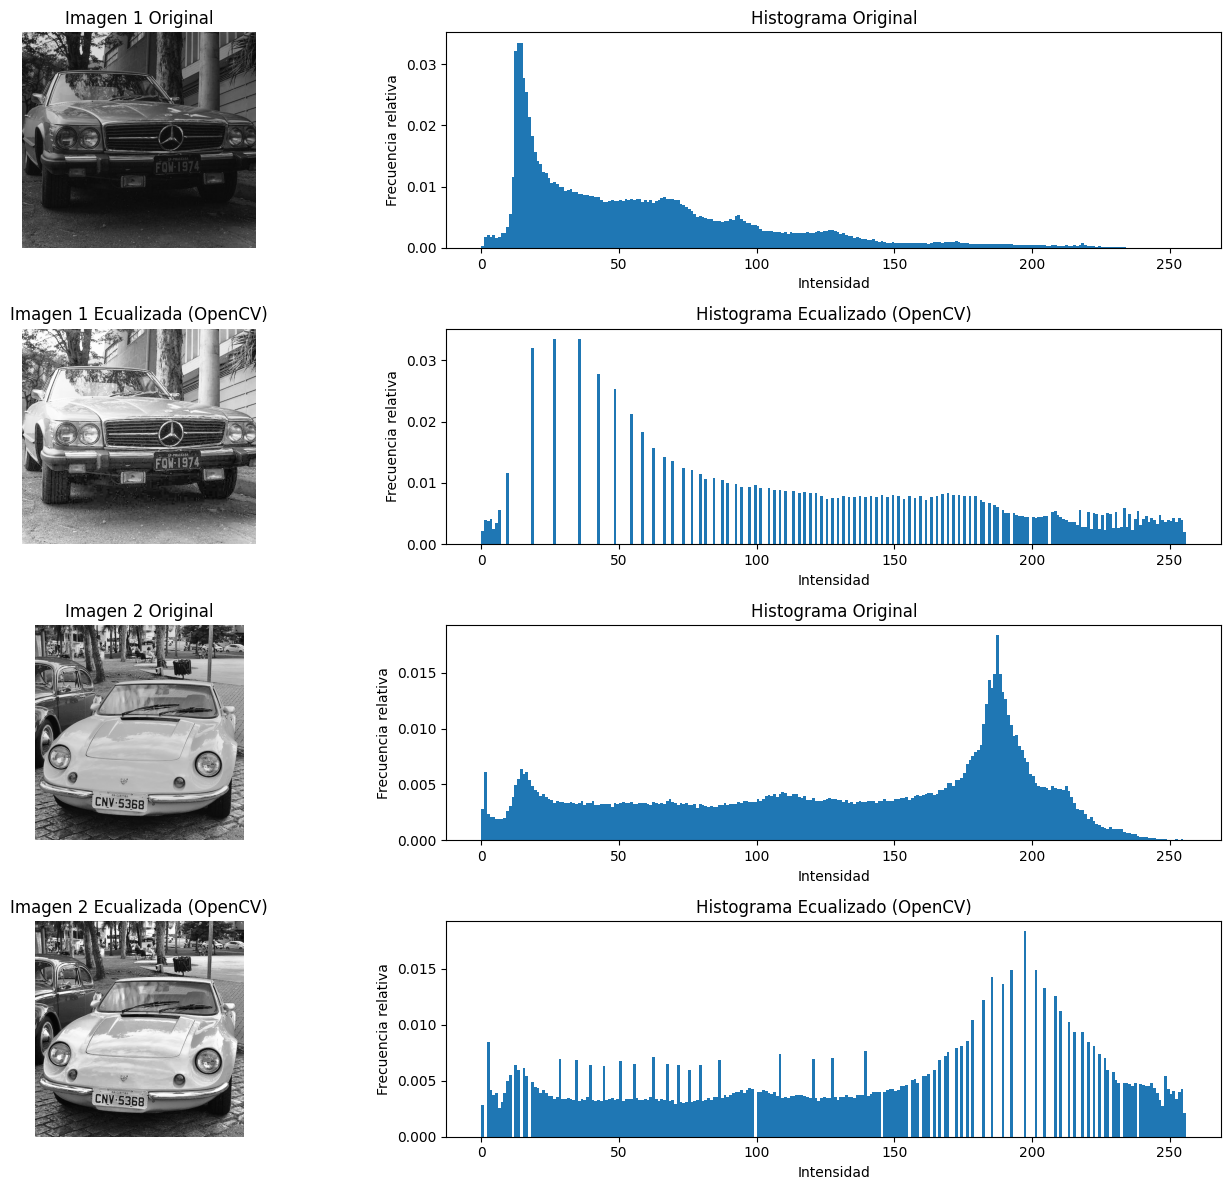

In [10]:
#### 3.3 Técnica de ajuste (2) – **OpenCV**

# Aplicar ecualización de histograma con OpenCV
img1_eq_opencv = cv2.equalizeHist(img_low1_gray)
img2_eq_opencv = cv2.equalizeHist(img_low2_gray)


def visualizar_comparacion_opencv(img_orig1, img_eq1, img_orig2, img_eq2):
    plt.figure(figsize=(15, 12))
    
    # Primera imagen
    plt.subplot(421)
    plt.imshow(img_orig1, cmap='gray')
    plt.title('Imagen 1 Original')
    plt.axis('off')
    
    plt.subplot(422)
    plt.hist(img_orig1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(423)
    plt.imshow(img_eq1, cmap='gray')
    plt.title('Imagen 1 Ecualizada (OpenCV)')
    plt.axis('off')
    
    plt.subplot(424)
    plt.hist(img_eq1.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado (OpenCV)')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    # Segunda imagen
    plt.subplot(425)
    plt.imshow(img_orig2, cmap='gray')
    plt.title('Imagen 2 Original')
    plt.axis('off')
    
    plt.subplot(426)
    plt.hist(img_orig2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Original')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.subplot(427)
    plt.imshow(img_eq2, cmap='gray')
    plt.title('Imagen 2 Ecualizada (OpenCV)')
    plt.axis('off')
    
    plt.subplot(428)
    plt.hist(img_eq2.ravel(), bins=256, range=[0,256], density=True)
    plt.title('Histograma Ecualizado (OpenCV)')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia relativa')
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función
visualizar_comparacion_opencv(img_low1_gray, img1_eq_opencv, img_low2_gray, img2_eq_opencv)


### 3.4. **Visualización de resultados:**
   - Se muestran las imágenes originales y procesadas junto con sus histogramas, utilizando `cv2.calcHist` o `plt.hist`.

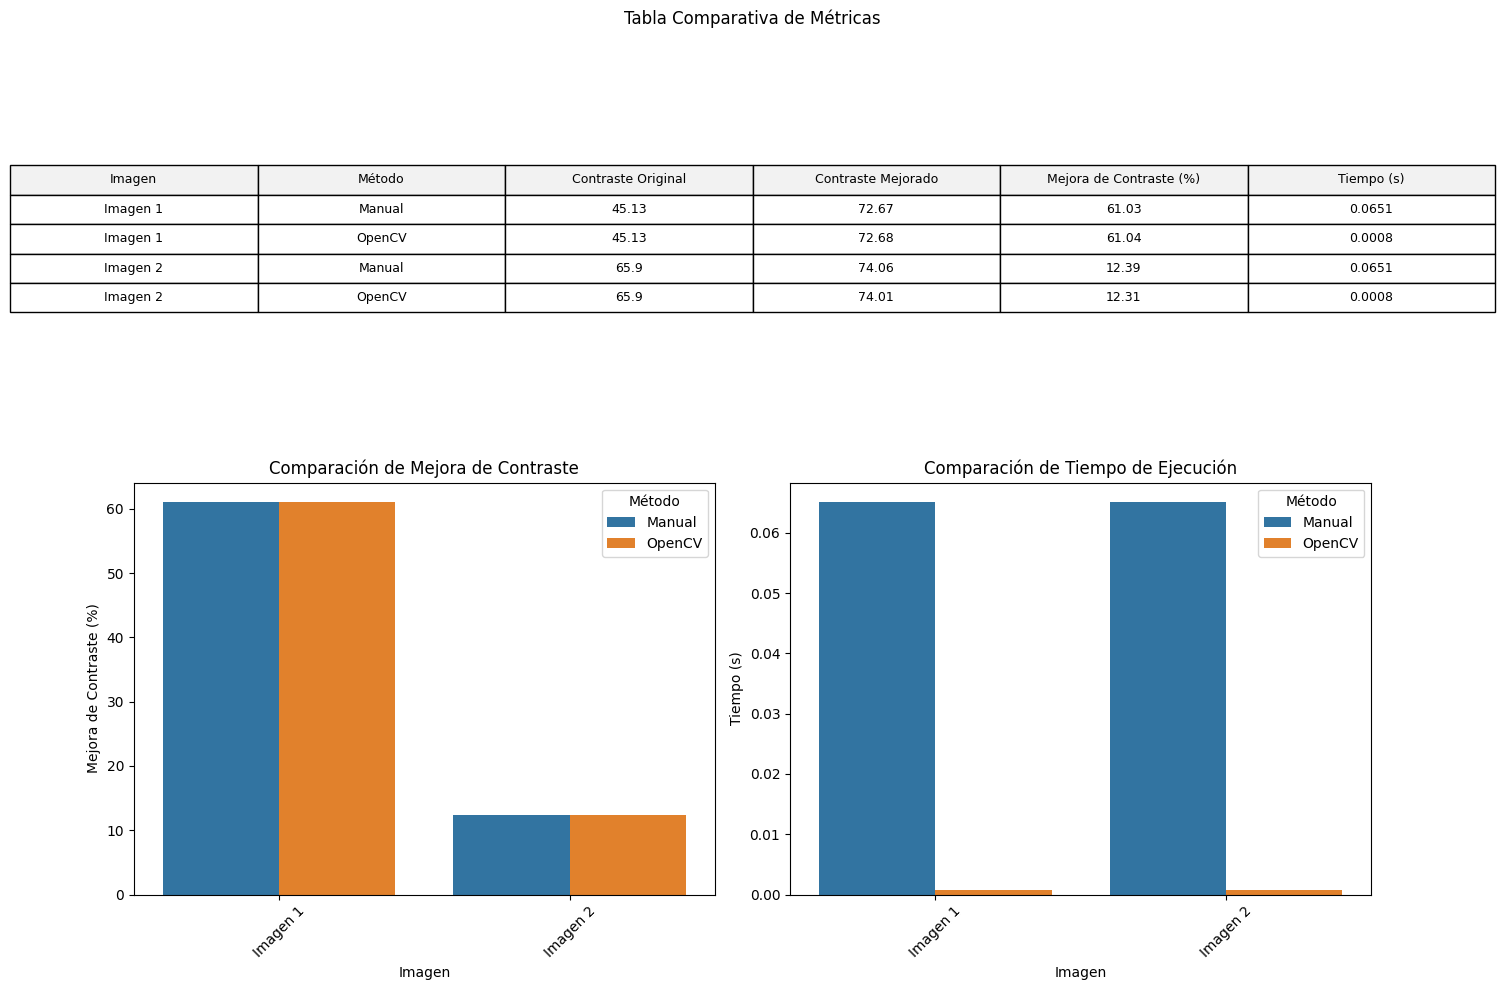

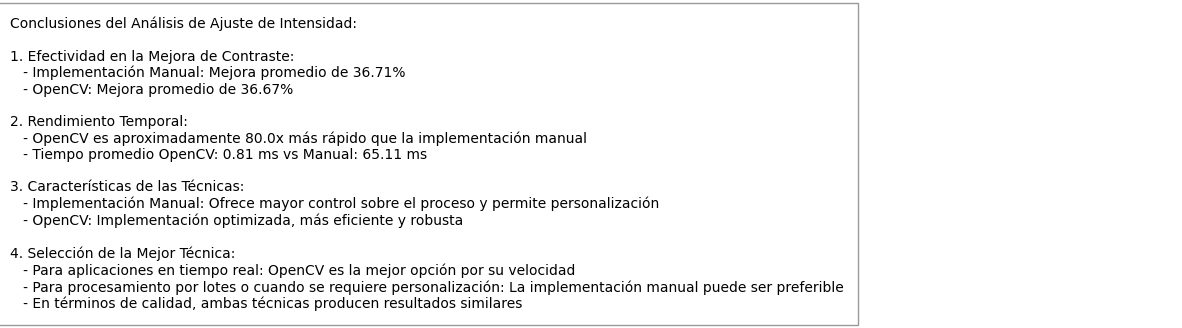

In [11]:
#### 3.4 Análisis Comparativo y Conclusiones

# Calcular métricas de contraste
def calcular_contraste(imagen):
    return np.std(imagen)

# Calcular tiempo de ejecución para ambos métodos
import time

# Medir tiempo para implementación manual
start_time = time.time()
_ = ecualizacion_histograma_manual(img_low1_gray)
tiempo_manual = time.time() - start_time

# Medir tiempo para OpenCV
start_time = time.time()
_ = cv2.equalizeHist(img_low1_gray)
tiempo_opencv = time.time() - start_time

# Crear DataFrame con métricas
metrics = {
    'Imagen': [],
    'Método': [],
    'Contraste Original': [],
    'Contraste Mejorado': [],
    'Mejora de Contraste (%)': [],
    'Tiempo (s)': []
}

# Calcular métricas para ambas imágenes y métodos
for img_num, (img_orig, img_manual, img_opencv) in enumerate([(img_low1_gray, img1_eq_manual, img1_eq_opencv),
                                                            (img_low2_gray, img2_eq_manual, img2_eq_opencv)], 1):
    # Contraste original
    contraste_orig = calcular_contraste(img_orig)
    
    # Método manual
    contraste_manual = calcular_contraste(img_manual)
    mejora_manual = ((contraste_manual - contraste_orig) / contraste_orig) * 100
    
    # Método OpenCV
    contraste_opencv = calcular_contraste(img_opencv)
    mejora_opencv = ((contraste_opencv - contraste_orig) / contraste_orig) * 100
    
    # Agregar al diccionario
    for metodo, contraste, mejora, tiempo in [('Manual', contraste_manual, mejora_manual, tiempo_manual),
                                            ('OpenCV', contraste_opencv, mejora_opencv, tiempo_opencv)]:
        metrics['Imagen'].append(f'Imagen {img_num}')
        metrics['Método'].append(metodo)
        metrics['Contraste Original'].append(round(contraste_orig, 2))
        metrics['Contraste Mejorado'].append(round(contraste, 2))
        metrics['Mejora de Contraste (%)'].append(round(mejora, 2))
        metrics['Tiempo (s)'].append(round(tiempo, 4))

# Crear DataFrame y mostrar resultados
df = pd.DataFrame(metrics)


def visualizar_resultados(df, tiempo_manual, tiempo_opencv):
    # Visualizar resultados
    plt.figure(figsize=(15, 10))

    # 1. Tabla de métricas (ocupa dos columnas)
    plt.subplot(211)
    plt.axis('off')
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*6)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Tabla Comparativa de Métricas')

    # 2. Gráfico de barras para Mejora de Contraste
    plt.subplot(223)
    sns.barplot(data=df, x='Imagen', y='Mejora de Contraste (%)', hue='Método')
    plt.title('Comparación de Mejora de Contraste')
    plt.xticks(rotation=45)

    # 3. Gráfico de barras para Tiempo
    plt.subplot(224)
    sns.barplot(data=df, x='Imagen', y='Tiempo (s)', hue='Método')
    plt.title('Comparación de Tiempo de Ejecución')
    plt.xticks(rotation=45)

    # Ajustar layout
    plt.tight_layout()

    # Mostrar conclusiones
    plt.figure(figsize=(15, 4))
    plt.axis('off')
    conclusion_text = (
        "Conclusiones del Análisis de Ajuste de Intensidad:\n\n"
        "1. Efectividad en la Mejora de Contraste:\n"
        f"   - Implementación Manual: Mejora promedio de {df[df['Método']=='Manual']['Mejora de Contraste (%)'].mean():.2f}%\n"
        f"   - OpenCV: Mejora promedio de {df[df['Método']=='OpenCV']['Mejora de Contraste (%)'].mean():.2f}%\n\n"
        "2. Rendimiento Temporal:\n"
        f"   - OpenCV es aproximadamente {tiempo_manual/tiempo_opencv:.1f}x más rápido que la implementación manual\n"
        f"   - Tiempo promedio OpenCV: {tiempo_opencv*1000:.2f} ms vs Manual: {tiempo_manual*1000:.2f} ms\n\n"
        "3. Características de las Técnicas:\n"
        "   - Implementación Manual: Ofrece mayor control sobre el proceso y permite personalización\n"
        "   - OpenCV: Implementación optimizada, más eficiente y robusta\n\n"
        "4. Selección de la Mejor Técnica:\n"
        "   - Para aplicaciones en tiempo real: OpenCV es la mejor opción por su velocidad\n"
        "   - Para procesamiento por lotes o cuando se requiere personalización: La implementación manual puede ser preferible\n"
        "   - En términos de calidad, ambas técnicas producen resultados similares"
    )
    plt.text(0, 0.5, conclusion_text, ha='left', va='center', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, pad=10))

    plt.show()

# Ejecutar la función
visualizar_resultados(df, tiempo_manual, tiempo_opencv)
